In [1]:
from math import sqrt
import numpy as np
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,RobustScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime
from keras.layers import Input, Bidirectional,Dropout,LSTM,Dense,Embedding,Flatten,Reshape, BatchNormalization,LeakyReLU
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Model,Sequential
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import seaborn as sn
import copy

In [149]:
df = pd.read_csv('Datasets\PCCA_Impute.csv')
df['Datetime']=pd.to_datetime(df['Datetime'])
df.set_index('Datetime',inplace=True)
df.head()

,PM2.5,PM10,NO2,NH3,SO2,CO,Ozone,Temp,RH,WS,WD
Datetime,,,,,,,,,,,
2017-01-11 00:00:00,332.50,494.00,107.45,100.97,55.50,3.00,8.90,31.38,80.75,0.72,143.00
2017-01-11 01:00:00,295.50,435.50,95.42,104.13,45.20,2.44,10.70,30.73,81.25,0.53,126.75
2017-01-11 02:00:00,270.00,395.00,77.62,99.42,29.12,1.97,12.18,30.65,82.00,0.60,161.25
2017-01-11 03:00:00,248.50,352.75,74.72,97.13,20.62,1.77,10.75,30.63,83.00,0.50,113.75
2017-01-11 04:00:00,261.75,365.50,82.20,97.62,17.85,1.65,8.72,31.23,85.25,0.85,104.00


In [150]:
df.describe()

,PM2.5,PM10,NO2,NH3,SO2,CO,Ozone,Temp,RH,WS,WD
count,33217.000000,33217.000000,33217.000000,33217.000000,33217.000000,33217.000000,33217.000000,33217.000000,33217.000000,33217.000000,33217.000000
mean,124.561004,248.468040,55.791880,40.117335,20.502858,1.474039,42.050464,29.118946,66.443967,1.706425,163.804515
std,123.232717,169.174701,41.572418,20.516775,23.154325,1.353425,35.969187,2.709875,18.374013,3.429883,90.431843
min,-0.721756,3.000000,0.030000,0.030000,0.100000,0.000000,0.100000,14.500000,7.000000,0.300000,1.000000
25%,43.250000,125.000000,24.520000,27.250000,6.700000,0.710000,15.830000,27.700000,53.500000,0.480000,108.500000
50%,83.250000,215.000000,48.100000,38.080000,13.050000,1.060000,31.800000,29.680000,67.500000,1.180000,164.250000
75%,161.750000,324.763034,76.500000,49.050000,24.120000,1.660000,54.920000,30.880000,81.000000,1.830000,240.250000
max,995.000000,999.250000,463.550000,462.400000,200.000000,15.420000,199.600000,59.750000,100.000000,50.000000,354.000000


In [151]:
df['WC']=df['WD']/df['WS']
df['TC']= df['Temp']-((100-df['RH'])/5)
df

,PM2.5,PM10,NO2,NH3,SO2,CO,Ozone,Temp,RH,WS,WD,WC,TC
Datetime,,,,,,,,,,,,,
2017-01-11 00:00:00,332.50,494.00,107.45,100.97,55.50,3.00,8.90,31.38,80.75,0.72,143.00,198.611111,27.53
2017-01-11 01:00:00,295.50,435.50,95.42,104.13,45.20,2.44,10.70,30.73,81.25,0.53,126.75,239.150943,26.98
2017-01-11 02:00:00,270.00,395.00,77.62,99.42,29.12,1.97,12.18,30.65,82.00,0.60,161.25,268.750000,27.05
2017-01-11 03:00:00,248.50,352.75,74.72,97.13,20.62,1.77,10.75,30.63,83.00,0.50,113.75,227.500000,27.23
2017-01-11 04:00:00,261.75,365.50,82.20,97.62,17.85,1.65,8.72,31.23,85.25,0.85,104.00,122.352941,28.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-11 19:00:00,316.25,709.50,139.25,46.30,16.30,4.47,38.43,31.07,81.25,0.32,151.00,471.875000,27.32
2021-12-11 20:00:00,397.75,743.75,148.68,43.05,16.62,4.98,39.30,29.60,84.50,0.30,151.00,503.333333,26.50
2021-12-11 21:00:00,471.50,765.75,137.30,40.27,15.95,0.01,37.17,29.57,86.75,0.30,151.00,503.333333,26.92


In [152]:
# df['dow']=df.index.day_of_week
# df['doy']=df.index.day_of_year
# df['moy']=df.index.month
# df['hour']=df.index.hour
# df['year']=df.index.year
# df_train=df[(df['year']<2021) | (df['moy']<=5)]
# df_test=df[(df['year']>=2021) & (df['moy']>=5)]

In [153]:
# features_to_scale = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'Ozone', 'Temp', 'RH','WS','WD']
features_to_scale = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'Ozone', 'Temp', 'RH','WS','WD','WC','TC']

def scaling(df,features_to_scale):
    scaler = RobustScaler()
    # scaler = MinMaxScaler()
    # scaler = StandardScaler()

    # Specify the features you want to scale

    # Fit the scaler to your data
    scaler.fit(df[features_to_scale])

    # Transform your data
    scaled_data = scaler.transform(df[features_to_scale])

    # Convert the scaled data array back to a DataFrame
    scaled_df = pd.DataFrame(scaled_data, columns=features_to_scale,index=df.index)

    # Now scaled_df contains the scaled values of your features using RobustScaler
    print(max(scaled_df['PM2.5']))
    print(min(scaled_df['PM2.5']))
    print(scaled_df.describe())

    return scaled_df,scaler

In [154]:
df[features_to_scale],scaler=scaling(df,features_to_scale)
df['dow']=df.index.day_of_week
df['doy']=df.index.day_of_year
df['moy']=df.index.month
df['hour']=df.index.hour
df['year']=df.index.year

7.694092827004219
-0.7086224155489037
              PM2.5          PM10           NO2           NH3           SO2  \
count  33217.000000  33217.000000  33217.000000  33217.000000  33217.000000   
mean       0.348616      0.167539      0.147978      0.093456      0.427833   
std        1.039939      0.846877      0.799777      0.941136      1.329181   
min       -0.708622     -1.061257     -0.924779     -1.745413     -0.743398   
25%       -0.337553     -0.450534     -0.453636     -0.496789     -0.364524   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.662447      0.549466      0.546364      0.503211      0.635476   
max        7.694093      3.925902      7.992497     19.464220     10.731917   

                 CO         Ozone          Temp            RH            WS  \
count  33217.000000  33217.000000  33217.000000  33217.000000  33217.000000   
mean       0.435830      0.262227     -0.176432     -0.038401      0.389945   
std        1.

In [155]:
df_train=df[(df['year']<2021) | (df['moy']<=5)]
df_test=df[(df['year']>=2021) & (df['moy']>=5)]

# Filter df_train to include only the last 14 values
last_14_values = df_train.tail(14)

# Append the last 14 values from df_train to df_test
df_test = pd.concat([last_14_values, df_test], axis=0)


In [156]:
df_train.drop(columns=['year'],inplace=True)
df_test.drop(columns=['year'],inplace=True)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23176\2659423081.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns=['year'],inplace=True)


In [157]:
df_train

,PM2.5,PM10,NO2,NH3,SO2,CO,Ozone,Temp,RH,WS,WD,WC,TC,dow,doy,moy,hour
Datetime,,,,,,,,,,,,,,,,,
2017-01-11 00:00:00,2.103376,1.396655,1.141785,2.884862,2.436854,2.042105,-0.585828,0.534591,0.481818,-0.340741,-0.161290,0.325994,0.805687,2,11,1,0
2017-01-11 01:00:00,1.791139,1.103808,0.910350,3.029817,1.845580,1.452632,-0.539780,0.330189,0.500000,-0.481481,-0.284630,0.505528,0.718799,2,11,1,1
2017-01-11 02:00:00,1.575949,0.901068,0.567911,2.813761,0.922503,0.957895,-0.501919,0.305031,0.527273,-0.429630,-0.022770,0.636610,0.729858,2,11,1,2
2017-01-11 03:00:00,1.394515,0.689567,0.512120,2.708716,0.434558,0.747368,-0.538501,0.298742,0.563636,-0.503704,-0.383302,0.453931,0.758294,2,11,1,3
2017-01-11 04:00:00,1.506329,0.753393,0.656022,2.731193,0.275545,0.621053,-0.590432,0.487421,0.645455,-0.244444,-0.457306,-0.011723,0.924171,2,11,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31 05:00:00,-0.232068,-0.121394,0.140439,-0.957798,1.522962,-0.178947,-0.273727,-1.455975,-0.127273,-0.466667,-0.006736,0.761819,-0.723539,0,151,5,5
2021-05-31 06:00:00,-0.075949,0.012515,0.074644,-0.925688,1.300230,-0.168421,-0.104886,-1.518868,-0.063636,-0.222222,-0.007090,0.268312,-0.699842,0,151,5,6
2021-05-31 07:00:00,0.002110,0.097616,-0.252020,-0.928899,0.238232,-0.284211,0.476337,-1.666667,-0.045455,0.014815,-0.007983,0.048708,-0.758294,0,151,5,7


In [158]:
df_test

,PM2.5,PM10,NO2,NH3,SO2,CO,Ozone,Temp,RH,WS,WD,WC,TC,dow,doy,moy,hour
Datetime,,,,,,,,,,,,,,,,,
2021-05-30 20:00:00,-0.362869,-0.023778,0.117353,-0.966055,2.062572,-0.147368,0.379893,-1.855346,-0.509091,0.000000,-0.007626,0.059093,-1.255924,6,150,5,20
2021-05-30 21:00:00,-0.335443,0.066329,0.044248,-0.981651,0.317451,-0.242105,0.161167,-1.676101,-0.490909,-0.429630,-0.007445,0.651513,-1.150079,6,150,5,21
2021-05-30 22:00:00,-0.392405,-0.404229,0.307426,-1.034404,-0.225603,-0.084211,-0.226401,-1.597484,-0.381818,-0.355556,-0.006557,0.480098,-1.015798,6,150,5,22
2021-05-30 23:00:00,-0.280591,-0.435516,0.035013,-0.989908,-0.061998,-0.284211,0.029931,-1.575472,-0.372727,-0.355556,-0.006778,0.479914,-0.996840,6,150,5,23
2021-05-31 00:00:00,-0.232068,-0.032539,-0.031743,-0.944954,0.324340,-0.357895,-0.039652,-1.581761,-0.290909,-0.266667,-0.007217,0.328359,-0.928910,0,151,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-11 19:00:00,1.966245,2.475433,1.753559,0.377064,0.186567,3.589474,0.169609,0.437107,0.500000,-0.637037,-0.100569,1.536168,0.772512,5,345,12,19
2021-12-11 20:00:00,2.654008,2.646886,1.934975,0.227982,0.204937,4.126316,0.191865,-0.025157,0.618182,-0.651852,-0.100569,1.675484,0.642970,5,345,12,20
2021-12-11 21:00:00,3.276371,2.757017,1.716045,0.100459,0.166475,-1.105263,0.137375,-0.034591,0.700000,-0.651852,-0.100569,1.675484,0.709321,5,345,12,21


In [159]:
columns=['PM2.5','PM10','NO2','NH3','SO2','CO','Ozone','Temp','RH','WS','WD','dow','moy','hour']
# columns=['PM2.5','PM10','NO2','NH3','SO2','CO','TC','WC','dow','moy','hour']
# columns=['PM2.5','PM10','TC','WC','dow','moy','hour']
df_train_values=df_train[columns].values

trainX shape == (28718, 24, 14).
trainY shape == (28718, 1).
Epoch 1/15
958/958 [==============================] - 61s 59ms/step - loss: 0.2774 - val_loss: 0.1325
Epoch 2/15
958/958 [==============================] - 57s 59ms/step - loss: 0.1998 - val_loss: 0.1227
Epoch 3/15
958/958 [==============================] - 56s 59ms/step - loss: 0.1865 - val_loss: 0.1159
Epoch 4/15
958/958 [==============================] - 57s 60ms/step - loss: 0.1774 - val_loss: 0.1253
Epoch 5/15
958/958 [==============================] - 58s 61ms/step - loss: 0.1687 - val_loss: 0.1279
Epoch 6/15
958/958 [==============================] - 57s 59ms/step - loss: 0.1640 - val_loss: 0.1310
Epoch 7/15
958/958 [==============================] - 57s 60ms/step - loss: 0.1573 - val_loss: 0.1369
Epoch 8/15
958/958 [==============================] - 54s 56ms/step - loss: 0.1526 - val_loss: 0.1176
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Outpu

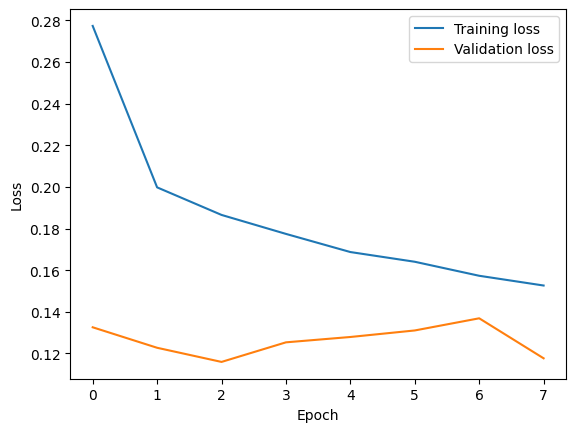

In [160]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past hours.
n_past = 24  # Number of past hours we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_train_values has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_train_values) - n_future +1):
    trainX.append(df_train_values[i - n_past:i, 0:df_train.shape[1]])
    trainY.append(df_train_values[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

# Define the Autoencoder model
model = Sequential()

model.add(Bidirectional(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True)))
model.add(LeakyReLU(0.15))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(LeakyReLU(0.15))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1],activation='linear'))
model.compile(optimizer='adam', loss='mse')

cp=ModelCheckpoint('models/model_epoch_{epoch:02d}.h5',save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# fit the model
history = model.fit(trainX, trainY, epochs=15, batch_size=24, validation_split=0.2, verbose=1,callbacks=[cp,early_stopping])

model.summary()

# Print final training and validation loss
print("Final training loss:", history.history['loss'][-1])
print("Final validation loss:", history.history['val_loss'][-1])

# Plot loss curves
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/15
958/958 [==============================] - 42s 43ms/step - loss: 0.1524 - val_loss: 0.1272
Epoch 2/15
958/958 [==============================] - 40s 42ms/step - loss: 0.1487 - val_loss: 0.1290
Epoch 3/15
958/958 [==============================] - 41s 43ms/step - loss: 0.1438 - val_loss: 0.1282
Epoch 4/15
958/958 [==============================] - 43s 45ms/step - loss: 0.1425 - val_loss: 0.1408
Epoch 5/15
958/958 [==============================] - 41s 43ms/step - loss: 0.1373 - val_loss: 0.1275
Epoch 6/15
958/958 [==============================] - 42s 44ms/step - loss: 0.1279 - val_loss: 0.1324
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_11 (Bidirecti  (None, 24, 256)          146432    
 onal)                                                           
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None,

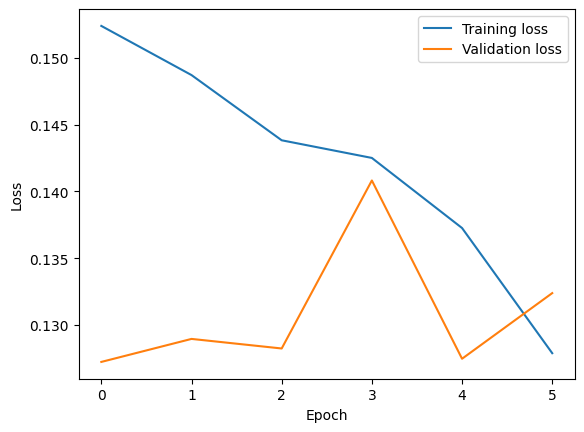

In [170]:
# fit the model
history = model.fit(trainX, trainY, epochs=15, batch_size=24, validation_split=0.2, verbose=1,callbacks=[cp,early_stopping])

model.summary()

# Print final training and validation loss
print("Final training loss:", history.history['loss'][-1])
print("Final validation loss:", history.history['val_loss'][-1])

# Plot loss curves
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

testX shape == (5171, 24, 14).
testY shape == (5171, 1).
test shape == (1, 0, 14).
162/162 [==============================] - 3s 17ms/step
Mean Squared Error (MSE): 0.05528223922694145
Root Mean Squared Error (RMSE): 0.23512175404870866


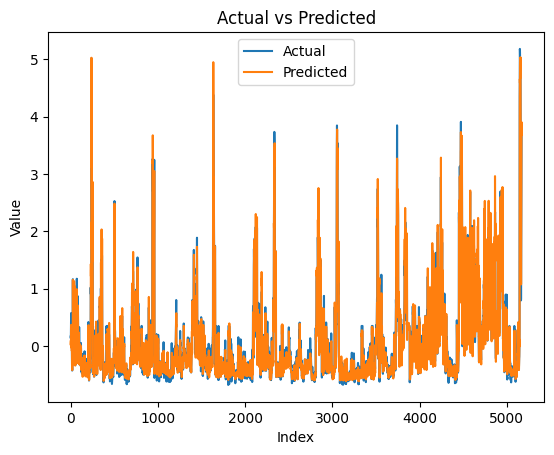

In [175]:
# model.load_weights('./Best_Models/2.h5')

# Extract the values from the test dataset
df_test_values = df_test[columns].values

# Similar to the training data, prepare the test data in the required shape
testX = []
testY = []

# Use the same parameters as used for training
for i in range(n_past, len(df_test_values) - n_future + 1):
    testX.append(df_test_values[i - n_past:i, 0:df_test.shape[1]])
    testY.append(df_test_values[i + n_future - 1:i + n_future, 0])

testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

test=[]
test.append(df_test_values[14- n_past:14, 0:df_test.shape[1]])
test=np.array(test)
print('test shape == {}.'.format(test.shape))

# Make predictions on the test data
predictions = model.predict(testX)

# Flatten the predictions and actual values arrays
# predictions = predictions.flatten()
# actual_values = testY.flatten()
actual_values= testY

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predictions)
print('Mean Squared Error (MSE):', mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = sqrt(mse)
print('Root Mean Squared Error (RMSE):', rmse)

# Plot actual vs predicted values
plt.plot(actual_values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

(5171, 13)
Mean Squared Error (MSE): 776.2870241478714
Root Mean Squared Error (RMSE): 27.861927861292575


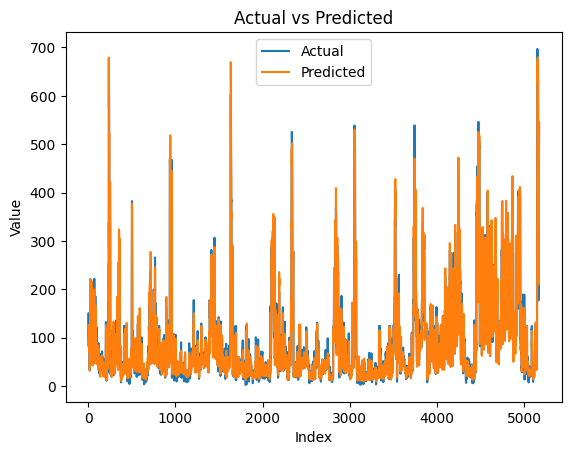

In [176]:
predictions= np.repeat(predictions, 13, axis=-1)
actual_values=np.repeat(actual_values, 13, axis=-1)

print(predictions.shape)

predictions = scaler.inverse_transform(predictions)[:,0]
actual_values= scaler.inverse_transform(actual_values)[:,0]

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predictions)
print('Mean Squared Error (MSE):', mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = sqrt(mse)
print('Root Mean Squared Error (RMSE):', rmse)

# Plot actual vs predicted values
plt.plot(actual_values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

In [173]:
# model.save('./Best_Models/1.h5')

# Model Details
# columns=['PM2.5','PM10','NO2','NH3','SO2','CO','Ozone','Temp','RH','WS','WD','dow','moy','hour']
# model = Sequential()
# model.add(Bidirectional(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True)))
# model.add(LeakyReLU(0.2))
# model.add(Dropout(0.2))
# model.add(LSTM(32, return_sequences=False))
# model.add(LeakyReLU(0.2))
# model.add(Dropout(0.2))
# model.add(Dense(trainY.shape[1],activation='linear'))
# model.compile(optimizer='adam', loss='mse')


In [174]:
# model.save('./Best_Models/2.h5') # Trained for 8 Epochs - RMSE - 27.43
# model.save('./Best_Models/3.h5') # Trained for longer 17 Epochs - RMSE - 26.80

# Model Details
# columns=['PM2.5','PM10','NO2','NH3','SO2','CO','Ozone','Temp','RH','WS','WD','dow','moy','hour']
# Define the Autoencoder model
# model = Sequential()
# model.add(Bidirectional(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True)))
# model.add(LeakyReLU(0.15))
# model.add(Dropout(0.2))
# model.add(LSTM(64, return_sequences=False))
# model.add(LeakyReLU(0.15))
# model.add(Dropout(0.2))
# model.add(Dense(trainY.shape[1],activation='linear'))
# model.compile(optimizer='adam', loss='mse')